In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import datetime
import numpy as np
from sklearn.compose import ColumnTransformer

In [2]:
# Load the data
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(data.head())

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop                          job  \
0  ...  62220  38.5127  -89.9847    

In [3]:
# Split by is_fraud
is_fraud = data['is_fraud']
not_fraud = data[is_fraud == 0]

# get some statistics
print('Number of frauds:', len(data[is_fraud == 1]))
print('Number of non-frauds:', len(data[is_fraud == 0]))

Number of frauds: 42299
Number of non-frauds: 328404


In [4]:
# Check if the first last names occurs in both data set, if only in test set count the number
full_name = data['first'] + ' ' + data['last']
full_name_test = test['first'] + ' ' + test['last']
# Check if all names in the test set are in the training set

# Check if names in the test set are in the training set
names_in_train = full_name_test.isin(full_name)

# Count the number of names only in the test set
names_only_in_test_count = (~names_in_train).sum()

print("Number of names only in the test set:", names_only_in_test_count)



Number of names only in the test set: 120


In [6]:
# Check if all credit number is in the training set
credit_card_in_train = test['cc_num'].isin(data['cc_num'])
names_only_in_test_count = (~credit_card_in_train).sum()
print("Number of credit card only in the test set:", names_only_in_test_count)

Number of credit card only in the test set: 151


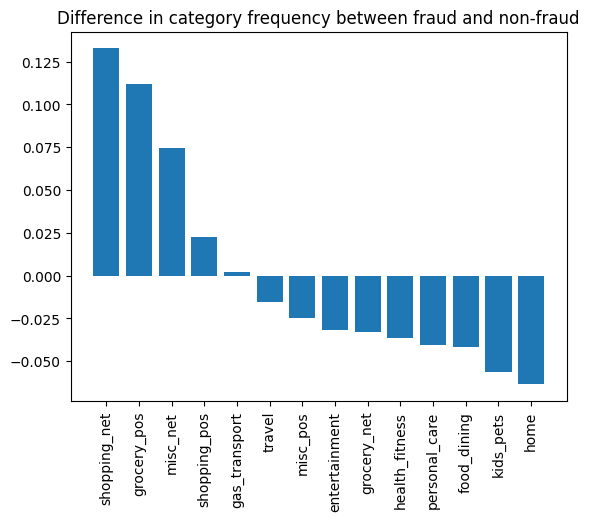

In [4]:
# Plot the distribution of category, count the frequency of each category, and sort by frequency
is_fraud_category = data['category'][data['is_fraud'] == 1].value_counts()
not_fraud_category = data['category'][data['is_fraud'] == 0].value_counts()
# Normalize the frequency
is_fraud_category = is_fraud_category / is_fraud_category.sum()
not_fraud_category = not_fraud_category / not_fraud_category.sum()

# Find the most different categories
diff_category = is_fraud_category - not_fraud_category
diff_category = diff_category.sort_values(ascending=False)
# Plot the 20 most different categories
plt.figure()
plt.bar(diff_category.index[:20], diff_category[:20])
plt.xticks(rotation=90)
plt.title('Difference in category frequency between fraud and non-fraud')
plt.show()

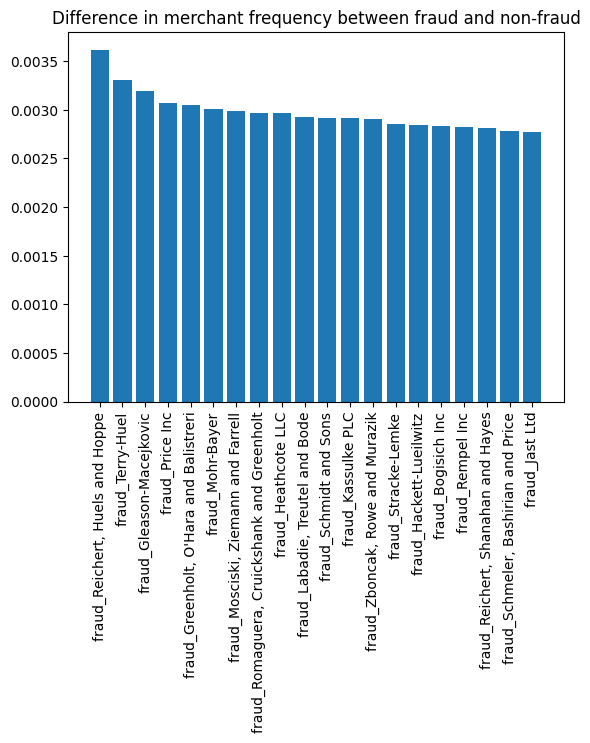

In [5]:
# Plot the distribution of merchant, count the frequency of each merchant, and sort by frequency
is_fraud_merchant = data['merchant'][data['is_fraud'] == 1].value_counts()
not_fraud_merchant = data['merchant'][data['is_fraud'] == 0].value_counts()
# Normalize the frequency
is_fraud_merchant = is_fraud_merchant / is_fraud_merchant.sum()
not_fraud_merchant = not_fraud_merchant / not_fraud_merchant.sum()

# Find the most different categories
diff_merchant = is_fraud_merchant - not_fraud_merchant
diff_merchant = diff_merchant.sort_values(ascending=False)
# Plot the 20 most different categories
plt.figure()
plt.bar(diff_merchant.index[:20], diff_merchant[:20])
plt.xticks(rotation=90)
plt.title('Difference in merchant frequency between fraud and non-fraud')
plt.show()

In [6]:
# Convert categorical data to unique integers
# Combine train and test data
combined_data = pd.concat([data, test], keys=['train', 'test'])

# Convert categorical columns to category type and get the codes
for col in ['category', 'merchant', 'job', 'gender']:
    combined_data[col] = combined_data[col].astype('category').cat.codes

# Split the combined data back into train and test data
train_data = combined_data.xs('train')
test_data = combined_data.xs('test')

In [7]:
def preprocess(data):
    # Get only the hour in trans_time
    data['trans_hour'] = data['trans_time'].str.slice(0, 2).astype(int)

    # Get the day of the week
    data['day_of_week'] = data['trans_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())

    # Compute difference between lat, long, merch_lat, merch_long
    data['location_diff'] = abs(data['lat'] - data['merch_lat']) + abs(data['long'] - data['merch_long'])

    # Compute the difference between dob and trans_date to get the age
    data['year_of_birth'] = data['dob'].str.slice(0, 4).astype(int)
    data['trans_year'] = data['trans_date'].str.slice(0, 4).astype(int)
    data['age'] = data['trans_year'] - data['year_of_birth']

    # Create a new pd that only have certain columns
    data_new = data[['id', 'amt', 'city_pop', 'trans_hour', 'day_of_week', 'location_diff', 'age', 'category', 'merchant', 'job', 'gender', 'is_fraud']]
    return data_new

train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Write the processed data to a file
train_data.to_csv('data/train_processed.csv', index=False)
test_data.to_csv('data/test_processed.csv', index=False)

/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_30545/2313822055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['trans_hour'] = data['trans_time'].str.slice(0, 2).astype(int)
/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_30545/2313822055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_of_week'] = data['trans_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())
/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_30545/2313822055.py

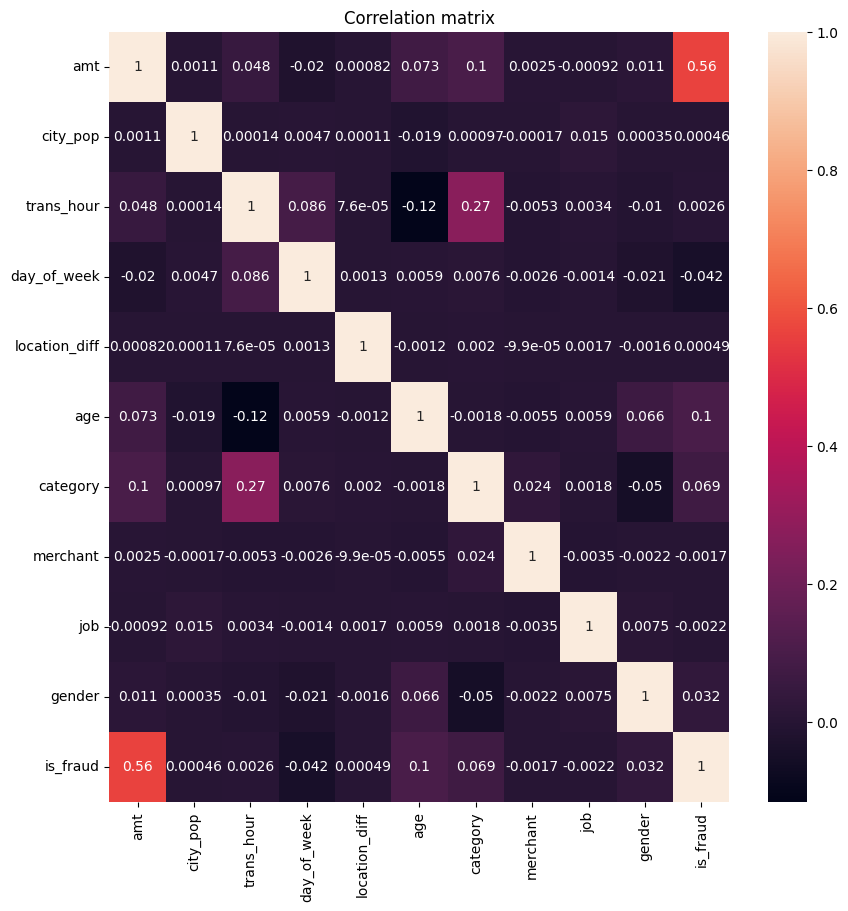

In [9]:
# Find the correlation between the features
corr = train_data.drop(columns=['id']).corr()
# Plot the correlation matrix, but bigger
plt.figure(figsize=(10, 10))
plt.title('Correlation matrix')
sns.heatmap(corr, annot=True)
plt.show()

In [8]:
def preprocess(data):
    # Get only the hour in trans_time
    data['trans_hour'] = data['trans_time'].str.slice(0, 2).astype(int)

    # Get the day of the week
    data['day_of_week'] = data['trans_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())
    
    # Get the month of the year
    data['trans_month'] = data['trans_date'].str.slice(5, 7).astype(int)

    # Compute difference between lat, long, merch_lat, merch_long
    data['location_diff'] = abs(data['lat'] - data['merch_lat']) + abs(data['long'] - data['merch_long'])

    # Compute the difference between dob and trans_date to get the age
    data['year_of_birth'] = data['dob'].str.slice(0, 4).astype(int)
    data['trans_year'] = data['trans_date'].str.slice(0, 4).astype(int)
    data['age'] = data['trans_year'] - data['year_of_birth']

    # Create a new pd that only have certain columns
    data_new = data[['id', 'amt', 'city_pop', 'trans_hour', 'day_of_week', 'trans_month', 'location_diff', 'age', 'category', 'merchant', 'job', 'gender', 'first', 'last', 'cc_num', 'is_fraud']]
    
    # Normalize the data
    # normalize amt
    data_new['amt'] = (data_new['amt'] - data_new['amt'].mean()) / data_new['amt'].std()
    # normalize city_pop
    data_new['city_pop'] = (data_new['city_pop'] - data_new['city_pop'].mean()) / data_new['city_pop'].std()
    # normalize trans_hour
    data_new['trans_hour'] = data_new['trans_hour'] / 23
    # normalize day_of_week
    data_new['day_of_week'] = data_new['day_of_week'] / 7
    # normalize trans_month
    data_new['trans_month'] = data_new['trans_month'] / 12
    # normalize location_diff
    data_new['location_diff'] = (data_new['location_diff'] - data_new['location_diff'].mean()) / data_new['location_diff'].std()
    # normalize age
    data_new['age'] = (data_new['age'] - data_new['age'].mean()) / data_new['age'].std()
    
    return data_new

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
# add is_fraud column to test_data
test_data['is_fraud'] = 0

train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Convert categorical data to unique integers
# Combine train and test data
combined_data = pd.concat([train_data, test_data], keys=['train', 'test'])

# Create full names
combined_data['full_name'] = combined_data['first'] + ' ' + combined_data['last']

# Calculate the fraud rate of each full name and cc_num in the training data
train_data = combined_data.xs('train')
full_name_fraud_rate = train_data.groupby('full_name')['is_fraud'].mean()
cc_num_fraud_rate = train_data.groupby('cc_num')['is_fraud'].mean()

# Map the fraud rates back to the combined data
combined_data['full_name_fraud_rate'] = combined_data['full_name'].map(full_name_fraud_rate)
combined_data['cc_num_fraud_rate'] = combined_data['cc_num'].map(cc_num_fraud_rate)

# Fill NaN values with 0 (or another appropriate value)
combined_data['full_name_fraud_rate'].fillna(0, inplace=True)
combined_data['cc_num_fraud_rate'].fillna(0, inplace=True)

combined_data.drop(columns=['first', 'last', 'full_name', 'cc_num'], inplace=True)


# Convert categorical columns to category type and get the codes
combined_data = pd.get_dummies(combined_data, columns=['category', 'merchant', 'job', 'gender'], drop_first=True)

# Split the combined data back into train and test data
train_data = combined_data.xs('train')
test_data = combined_data.xs('test')

# Write the processed data to a file
train_data.to_csv('data/train_normalized.csv', index=False)
test_data.to_csv('data/test_normalized.csv', index=False)


/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_95246/222416871.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['amt'] = (data_new['amt'] - data_new['amt'].mean()) / data_new['amt'].std()
/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_95246/222416871.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['city_pop'] = (data_new['city_pop'] - data_new['city_pop'].mean()) / data_new['city_pop'].std()
/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_95246/2

In [ ]:
def preprocess(data):
    # Get only the hour in trans_time
    data['trans_hour'] = data['trans_time'].str.slice(0, 2).astype(int)

    # Get the day of the week
    data['day_of_week'] = data['trans_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())
    
    # Get the month of the year
    data['trans_month'] = data['trans_date'].str.slice(5, 7).astype(int)

    # Compute difference between lat, long, merch_lat, merch_long
    data['location_diff'] = abs(data['lat'] - data['merch_lat']) + abs(data['long'] - data['merch_long'])

    # Compute the difference between dob and trans_date to get the age
    data['year_of_birth'] = data['dob'].str.slice(0, 4).astype(int)
    data['trans_year'] = data['trans_date'].str.slice(0, 4).astype(int)
    data['age'] = data['trans_year'] - data['year_of_birth']

    # Create a new pd that only have certain columns
    data_new = data[['id', 'amt', 'city_pop', 'trans_hour', 'day_of_week', 'trans_month', 'location_diff', 'age', 'category', 'merchant', 'job', 'gender', 'is_fraud']]
    
    # Normalize the data
    # normalize amt
    data_new['amt'] = (data_new['amt'] - data_new['amt'].mean()) / data_new['amt'].std()
    # normalize city_pop
    data_new['city_pop'] = (data_new['city_pop'] - data_new['city_pop'].mean()) / data_new['city_pop'].std()
    # normalize trans_hour
    data_new['trans_hour'] = data_new['trans_hour'] / 23
    # normalize day_of_week
    data_new['day_of_week'] = data_new['day_of_week'] / 6
    # normalize trans_month
    data_new['trans_month'] = data_new['trans_month'] / 12
    # normalize location_diff
    data_new['location_diff'] = (data_new['location_diff'] - data_new['location_diff'].mean()) / data_new['location_diff'].std()
    # normalize age
    data_new['age'] = (data_new['age'] - data_new['age'].mean()) / data_new['age'].std()
    
    return data_new

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
# add is_fraud column to test_data
test_data['is_fraud'] = -1

train_data = preprocess(train_data)
test_data = preprocess(test_data)

# categorical_cols = ['category', 'merchant', 'job', 'gender']
categorical_cols = ['job', 'gender']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Ignore unknown categories in test data

# Fit the encoder on the training data only
encoder.fit(train_data[categorical_cols])

# Transform both train and test data using the same encoder
train_transformed = encoder.transform(train_data[categorical_cols])
test_transformed = encoder.transform(test_data[categorical_cols])

# Convert the transformed arrays back to DataFrames with proper column names
train_encoded = pd.DataFrame(
    train_transformed, 
    columns=encoder.get_feature_names_out(categorical_cols), 
    index=train_data.index
)
test_encoded = pd.DataFrame(
    test_transformed, 
    columns=encoder.get_feature_names_out(categorical_cols), 
    index=test_data.index
)
print("Starts adding back")
# Add back the one-hot encoded categorical data to the original DataFrame
train_data = pd.concat([train_data.drop(columns=categorical_cols), train_encoded], axis=1)
test_data = pd.concat([test_data.drop(columns=categorical_cols), test_encoded], axis=1)
print("Finished adding back")

print("Starts writing to file")
# Convert train_data and test_data to NumPy arrays
train_array = train_data.to_numpy()
test_array = test_data.to_numpy()

# Save the header separately
train_header = ','.join(train_data.columns)
test_header = ','.join(test_data.columns)

# Use numpy.savetxt for faster writing
np.savetxt('data/train_normalized.csv', train_array, delimiter=',', header=train_header, comments='', fmt='%s')
np.savetxt('data/test_normalized.csv', test_array, delimiter=',', header=test_header, comments='', fmt='%s')
print("Finished writing to file")